In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from pathlib import Path
import cv2
import math
from pyzbar.pyzbar import decode as pyzbar_decode

# 警告を非表示にする
import warnings
warnings.filterwarnings('ignore')

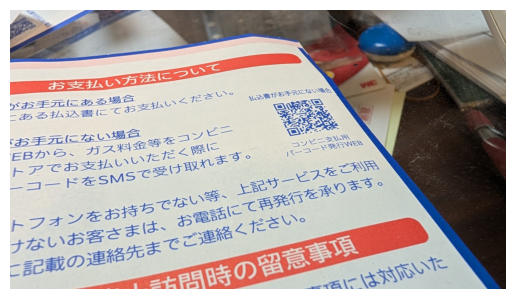

In [45]:
# image_path = Path("exmples/test_qr.png")
# image_path = Path("exmples/2025-04-26 21.24.27.jpg")
image_path = Path("exmples/2025-04-26 21.24.03.jpg")


img = cv2.imread(str(image_path))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# まずは表示
plt.axis('off')
plt.imshow(img)
plt.show()


In [47]:
qr_param = pyzbar_decode(img)
qr_param

[Decoded(data=b'https://reception.tokyo-gas.co.jp/tgcbpay\x00\x01\x0f\x14\x11\x1c\x0f\x08\x14', type='QRCODE', rect=Rect(left=2137, top=720, width=546, height=305), polygon=[Point(x=2137, y=766), Point(x=2280, y=1025), Point(x=2683, y=961), Point(x=2517, y=720)], quality=1, orientation='UP')]

In [55]:
qr_code_polygon = qr_param[0].polygon
qr_code_orientation = qr_param[0].orientation
qr_code_polygon, qr_code_orientation

([Point(x=2137, y=766),
  Point(x=2280, y=1025),
  Point(x=2683, y=961),
  Point(x=2517, y=720)],
 'UP')

In [57]:
# orientationのパラメータに応じて、pointの順序を変える

if qr_code_orientation == "UP":
    pass
elif qr_code_orientation == "RIGHT":
    qr_code_polygon = [qr_code_polygon[3], qr_code_polygon[0], qr_code_polygon[1], qr_code_polygon[2]]
elif qr_code_orientation == "DOWN":
    qr_code_polygon = [qr_code_polygon[2], qr_code_polygon[3], qr_code_polygon[0], qr_code_polygon[1]]
elif qr_code_orientation == "LEFT":
    qr_code_polygon = [qr_code_polygon[1], qr_code_polygon[2], qr_code_polygon[3], qr_code_polygon[0]]
else:
    raise ValueError("Invalid orientation value")
qr_code_polygon, qr_code_orientation

([Point(x=2137, y=766),
  Point(x=2280, y=1025),
  Point(x=2683, y=961),
  Point(x=2517, y=720)],
 'UP')

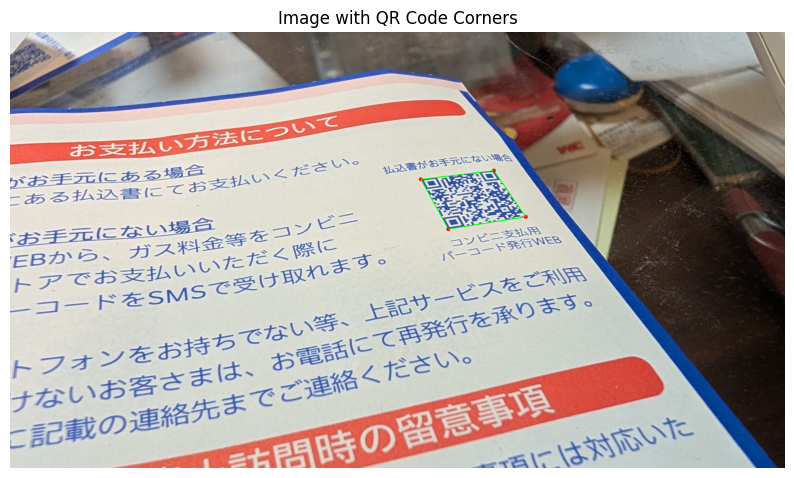

QR Code content: https://reception.tokyo-gas.co.jp/tgcbpay 


In [58]:
# Convert QR code polygon points to numpy array
points = np.array([[p.x, p.y] for p in qr_code_polygon], dtype=np.float32)

# Create a copy of the original image to draw on
img_with_points = img.copy()

# Draw polygon points on the image for visualization
for i, point in enumerate(points):
    pt1 = (int(point[0]), int(point[1]))
    pt2 = (int(points[(i+1) % 4][0]), int(points[(i+1) % 4][1]))
    cv2.circle(img_with_points, pt1, 10, (255, 0, 0), -1)
    cv2.line(img_with_points, pt1, pt2, (0, 255, 0), 3)

# Display the image with QR code corners
plt.figure(figsize=(10, 8))
plt.imshow(img_with_points)
plt.axis('off')
plt.title('Image with QR Code Corners')
plt.show()

# Print QR code content
print("QR Code content:", qr_param[0].data.decode('utf-8'))

# 画像全体を透視変換して元に戻す

QRコードの形状から画像全体の歪みを修正します。

Average QR code side length: 344.83 pixels
QR code center: (2404.25, 868.00)


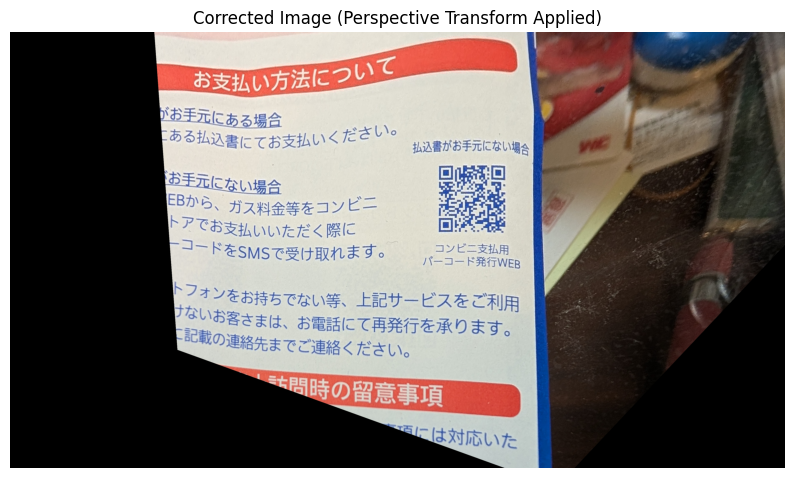

In [ ]:
# Get image dimensions
original_height, original_width = img.shape[:2]

# Assuming the QR code should be a square in real world
# Calculate the average side length of the QR code
side_lengths = []
for i in range(4):
    p1 = points[i]
    p2 = points[(i+1) % 4]
    side_lengths.append(np.sqrt(((p2[0] - p1[0]) ** 2) + ((p2[1] - p1[1]) ** 2)))

avg_side_length = np.mean(side_lengths)
print(f"Average QR code side length: {avg_side_length:.2f} pixels")

# Define what a perfect square QR code should look like at the same position
# We'll use the center of the detected QR code as reference
center_x = np.mean(points[:, 0])
center_y = np.mean(points[:, 1])
print(f"QR code center: ({center_x:.2f}, {center_y:.2f})")

# Create points for an ideal square QR code centered at the same position
half_side = avg_side_length / 2
ideal_qr_points = np.array([
    [center_x - half_side, center_y - half_side],  # top-left
    [center_x - half_side, center_y + half_side],  # bottom-left
    [center_x + half_side, center_y + half_side],  # bottom-right
    [center_x + half_side, center_y - half_side]   # top-right
], dtype=np.float32)

# Calculate the perspective transform matrix from detected points to ideal points
perspective_matrix = cv2.getPerspectiveTransform(points, ideal_qr_points)

# Apply perspective transformation to the entire image
corrected_img = cv2.warpPerspective(img, perspective_matrix, (original_width, original_height))


for i, point in enumerate(ideal_qr_points):
    x, y = point
    print(f"Point {i+1}: ({x:.2f}, {y:.2f})")
    
    # 座標に円と番号を描画
    cv2.circle(corrected_img, (int(x), int(y)), 10, (255, 0, 0), -1)
    cv2.putText(corrected_img, str(i+1), (int(x)+15, int(y)+15), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # 隣の点との間に線を引く
    next_point = ideal_qr_points[(i+1) % 4]
    cv2.line(corrected_img, 
             (int(x), int(y)), 
             (int(next_point[0]), int(next_point[1])), 
             (0, 255, 0), 3)


# Display the corrected image
plt.figure(figsize=(10, 8))
plt.imshow(corrected_img)
plt.axis('off')
plt.title('Corrected Image (Perspective Transform Applied)')
plt.show()

# 計算によるQRコードの4隅の座標の表示

透視変換後の画像におけるQRコードの4隅の座標を、透視変換マトリックスから計算して表示します。

計算されたQRコードの座標:
Point 1: (2231.84, 695.59)
Point 2: (2231.84, 1040.41)
Point 3: (2576.66, 1040.41)
Point 4: (2576.66, 695.59)


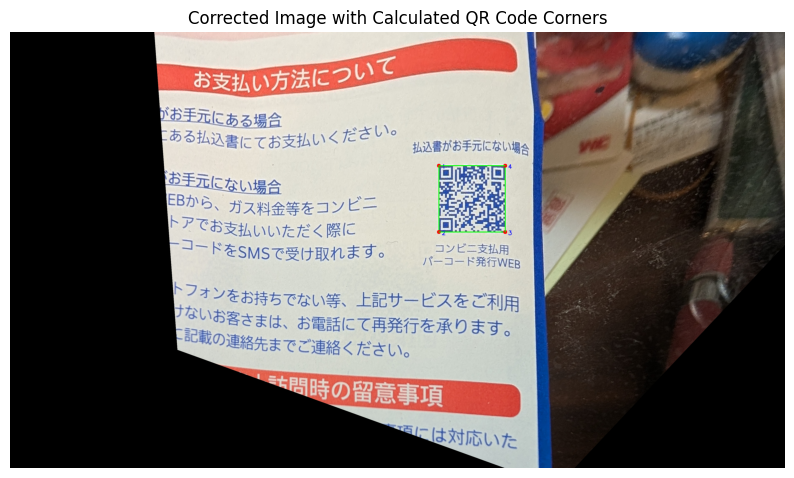


元の歪んだQRコードの座標と理想的なQRコードの座標の比較:
Point 1: Original (2137.00, 766.00) → Ideal (2231.84, 695.59)
Point 2: Original (2280.00, 1025.00) → Ideal (2231.84, 1040.41)
Point 3: Original (2683.00, 961.00) → Ideal (2576.66, 1040.41)
Point 4: Original (2517.00, 720.00) → Ideal (2576.66, 695.59)


In [59]:
# 透視変換後のQRコードの座標を表示（再検出ではなく計算で求める）
# 描画用の画像コピー
corrected_with_calculated_points = corrected_img.copy()

# 理想的なQRコードの座標（すでに計算済み）
print("計算されたQRコードの座標:")
for i, point in enumerate(ideal_qr_points):
    x, y = point
    print(f"Point {i+1}: ({x:.2f}, {y:.2f})")
    
    # 座標に円と番号を描画
    cv2.circle(corrected_with_calculated_points, (int(x), int(y)), 10, (255, 0, 0), -1)
    cv2.putText(corrected_with_calculated_points, str(i+1), (int(x)+15, int(y)+15), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # 隣の点との間に線を引く
    next_point = ideal_qr_points[(i+1) % 4]
    cv2.line(corrected_with_calculated_points, 
             (int(x), int(y)), 
             (int(next_point[0]), int(next_point[1])), 
             (0, 255, 0), 3)

# 結果を表示
plt.figure(figsize=(10, 8))
plt.imshow(corrected_with_calculated_points)
plt.axis('off')
plt.title('Corrected Image with Calculated QR Code Corners')
plt.show()

# 元の歪んだQRコードの座標と計算されたQRコードの座標の比較
print("\n元の歪んだQRコードの座標と理想的なQRコードの座標の比較:")
for i in range(4):
    original_x, original_y = points[i]
    ideal_x, ideal_y = ideal_qr_points[i]
    print(f"Point {i+1}: Original ({original_x:.2f}, {original_y:.2f}) → Ideal ({ideal_x:.2f}, {ideal_y:.2f})")